# Sentiment Analysis COVID19 in Indonesia

## Preparation

### Import Libraries

In [1]:
# Import Library Standard
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import Library Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.pipeline import make_pipeline

# Import Library untuk Stemming
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [2]:
!pip install wordcloud
from wordcloud import WordCloud

In [3]:
# Read Dataset
data = pd.read_excel('covid19.xlsx')
# data = pd.read_excel('Dataset MRT Jakarta.xlsx')
data.head()

text     type  \
0  Beberapa bandara di Indonesia memamasang alat ...  neutral   
1  [NEWS] Kemenkes siap cegah penyebaran Virus Co...  neutral   
2  Virus Corona Menyebar di 13 Provinsi, Ini Peri...  neutral   
3  Corona Virus, virus yang muncul di China pada ...  neutral   
4  Khawatir virus Corona menyebar ke Indonesia, K...  neutral   

            timestamp              user_id        username  
0 2020-01-22 15:59:32   759692754985242625        kumparan  
1 2020-01-22 13:51:45            233402223  Kepulauan Riau  
2 2020-01-22 13:32:49  1204606076756213760   Pendaki Senja  
3 2020-01-22 12:32:35            773500070    Firstky - 🇲🇨  
4 2020-01-22 11:53:46  1214712160523173889        Andespen

### Data Exploration

In [4]:
df = data[['text', 'type']].copy()
df.rename(columns={'text':'komentar', 'type':'label'}, inplace=True)
print('Ukuran Dataset: ', df.shape)
df.head()

Ukuran Dataset:  (1199, 2)


komentar    label
0  Beberapa bandara di Indonesia memamasang alat ...  neutral
1  [NEWS] Kemenkes siap cegah penyebaran Virus Co...  neutral
2  Virus Corona Menyebar di 13 Provinsi, Ini Peri...  neutral
3  Corona Virus, virus yang muncul di China pada ...  neutral
4  Khawatir virus Corona menyebar ke Indonesia, K...  neutral

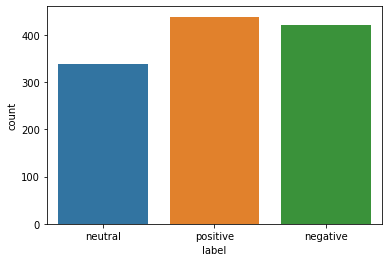

In [5]:
import seaborn as sns
sns.countplot(df['label']);

In [6]:
print("CONTOH KOMENTAR HASIL SCRAPPING\n")
for i in range(1,5):
      print(f"KOMENTAR{i}:\n {df['komentar'][i]}")

CONTOH KOMENTAR HASIL SCRAPPING

KOMENTAR1:
 [NEWS] Kemenkes siap cegah penyebaran Virus Corona di Indonesia https://kepri.antaranews.com/berita/61664/kemenkes-siap-cegah-penyebaran-virus-corona-di-indonesia …
KOMENTAR2:
 Virus Corona Menyebar di 13 Provinsi, Ini Perintah Xi Jinping

Awas aja, jgn ampe menyebar di provinsi2 di Indonesia.
 https://dunia.tempo.co/amp/1298433/virus-corona-menyebar-di-13-provinsi-ini-perintah-xi-jinping?utm_source=Digital%20Marketing&utm_medium=Twitter&utm_campaign=dlvrit&__twitter_impression=true …
KOMENTAR3:
 Corona Virus, virus yang muncul di China pada Desember lalu. Gejala mirip SARS Dan MERS.

Lethality 1 Dari 10 penderita meninggal.

Diduga disebarkan melalui hewan.

Indonesia sudah mengambil langkah pencegahan dengan pengecekan penerbangan dari china.

https://www.cnn.com/2020/01/20/health/what-is-coronavirus-explained/index.html …
KOMENTAR4:
 Khawatir virus Corona menyebar ke Indonesia, Kementerian Kesehatan menyiapkan termoscanner di 135 pintu ke

banyak komentar yang masih mengandung link http, spasi dan @akun sehingga perlu dibersihkan terlebih dahulu

## Preprocessing

### cleanning

In [7]:
def clean_tweet(tweet):
    """ cleaning tweet 
    source code: https://www.machinelearningplus.com/python/python-regex-tutorial-examples/
    """
    tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    tweet = re.sub('pic\.\S+', '', tweet)  # remove picture twitter URLs
    tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc
    tweet = re.sub('#\S+', '', tweet)  # remove hashtags
    tweet = re.sub('@\S+', '', tweet)  # remove mentions
    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet)  # remove punctuations
    tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
    return tweet

In [8]:
df['komentar'] = df['komentar'].apply(lambda x:clean_tweet(x))

In [9]:
for i in range(9,11):
    print(f"Contoh sebelum cleaning:\n\t{data['text'][i]}")
    print(f"Contoh setelah cleaning:\n\t{df['komentar'][i]}\n")

Contoh sebelum cleaning:
	Virus Corona Belum ada Vaksinnya, Ini Upaya Awal Kemenkes Cegah Penyebaran di Indonesia https://www.gosumut.com/berita/baca/2020/01/22/virus-corona-belum-ada-vaksinnya-ini-upaya-awal-kemenkes-cegah-penyebaran-di-indonesia/?utm_source=dlvr.it&utm_medium=twitter …
Contoh setelah cleaning:
	Virus Corona Belum ada Vaksinnya Ini Upaya Awal Kemenkes Cegah Penyebaran di Indonesia …

Contoh sebelum cleaning:
	Belum Ada Kasus Virus Corona di Indonesia - https://www.starjogja.com/2020/01/22/belum-ada-kasus-virus-corona-di-indonesia/ …pic.twitter.com/n1OKdWhSu0
Contoh setelah cleaning:
	Belum Ada Kasus Virus Corona di Indonesia …



In [10]:
negatif_komen = df[df['label'] == 'negative']['komentar'].values
neutral_komen = df[df['label'] == 'neutral']['komentar'].values
positif_komen = df[df['label'] == 'positive']['komentar'].values

### Spell Correction

#### Stemming

In [11]:
# Membuat stemmer
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

# Daftar Stopword
stopWordRemoverFactory = StopWordRemoverFactory()
stopwords = stopWordRemoverFactory.get_stop_words()

In [12]:
def word_cloud(x, stop=stopwords):
    words = WordCloud(width=3000, height=2000, stopwords=stop).generate(str(x))
    plt.figure(figsize=(40,30), edgecolor='k', facecolor='k')
    plt.imshow(words, interpolation='bilinear')
    plt.axis(False)
    plt.tight_layout(pad=0)
    plt.show()

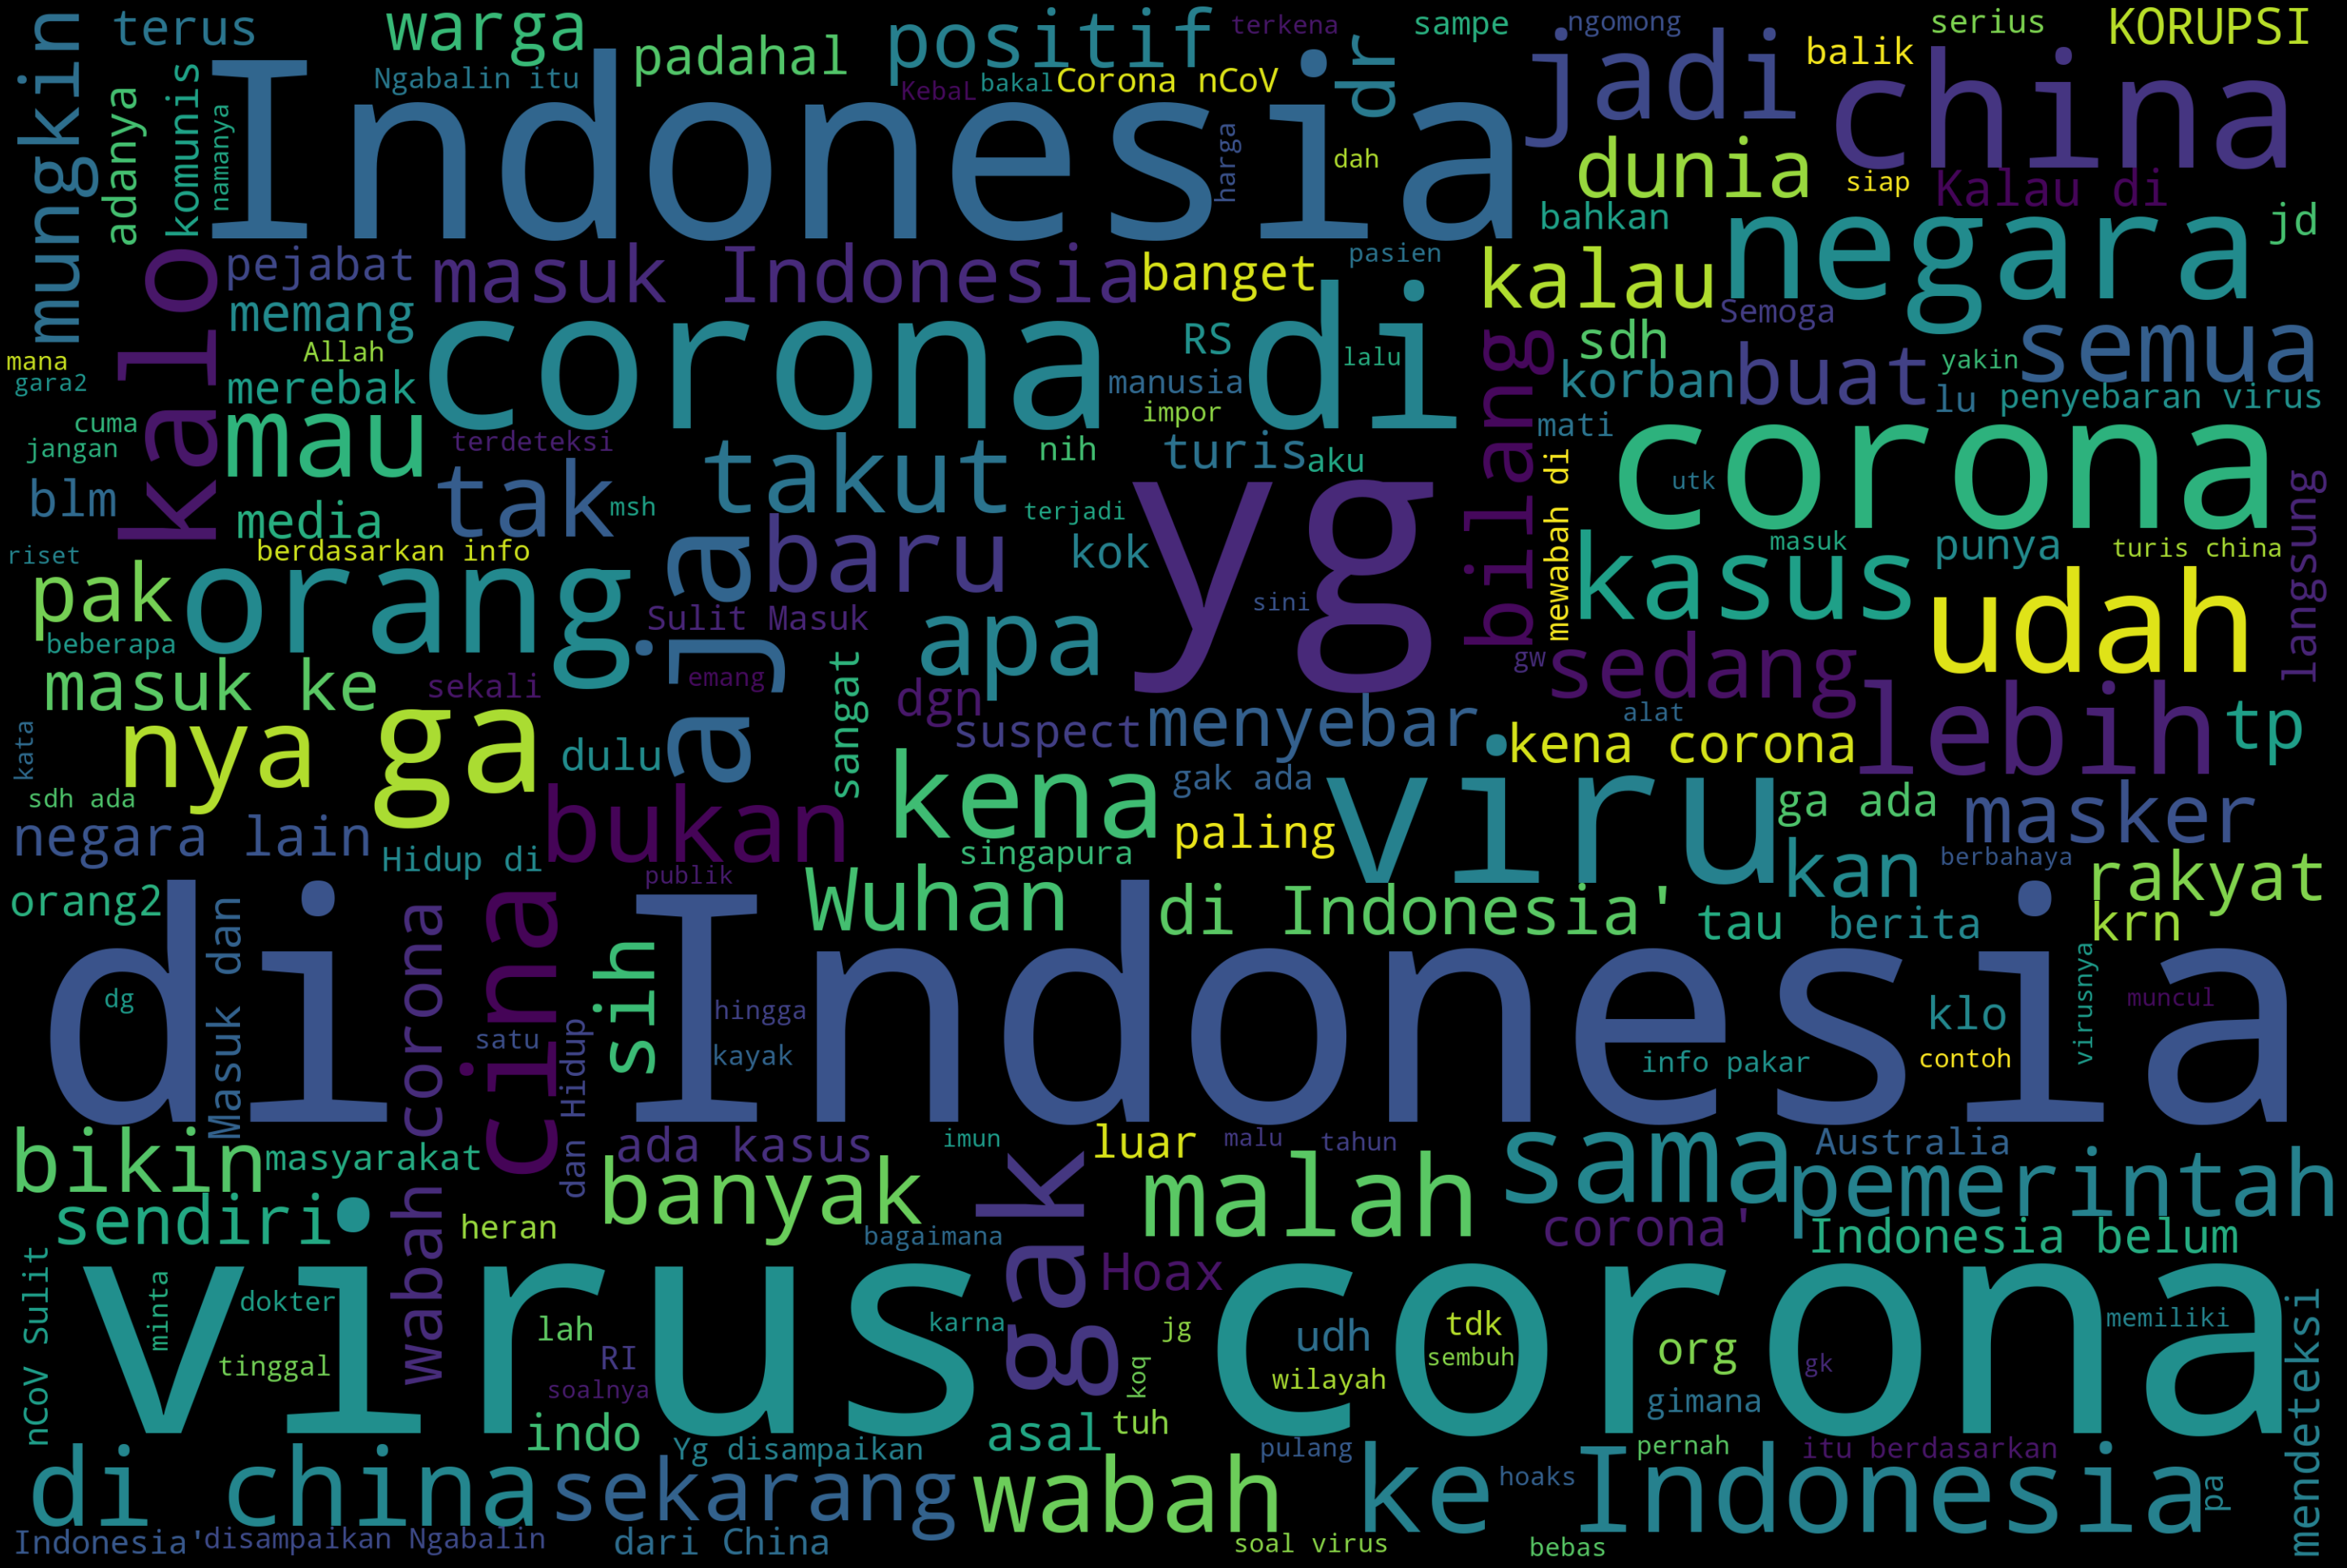

In [13]:
word_cloud(negatif_komen)

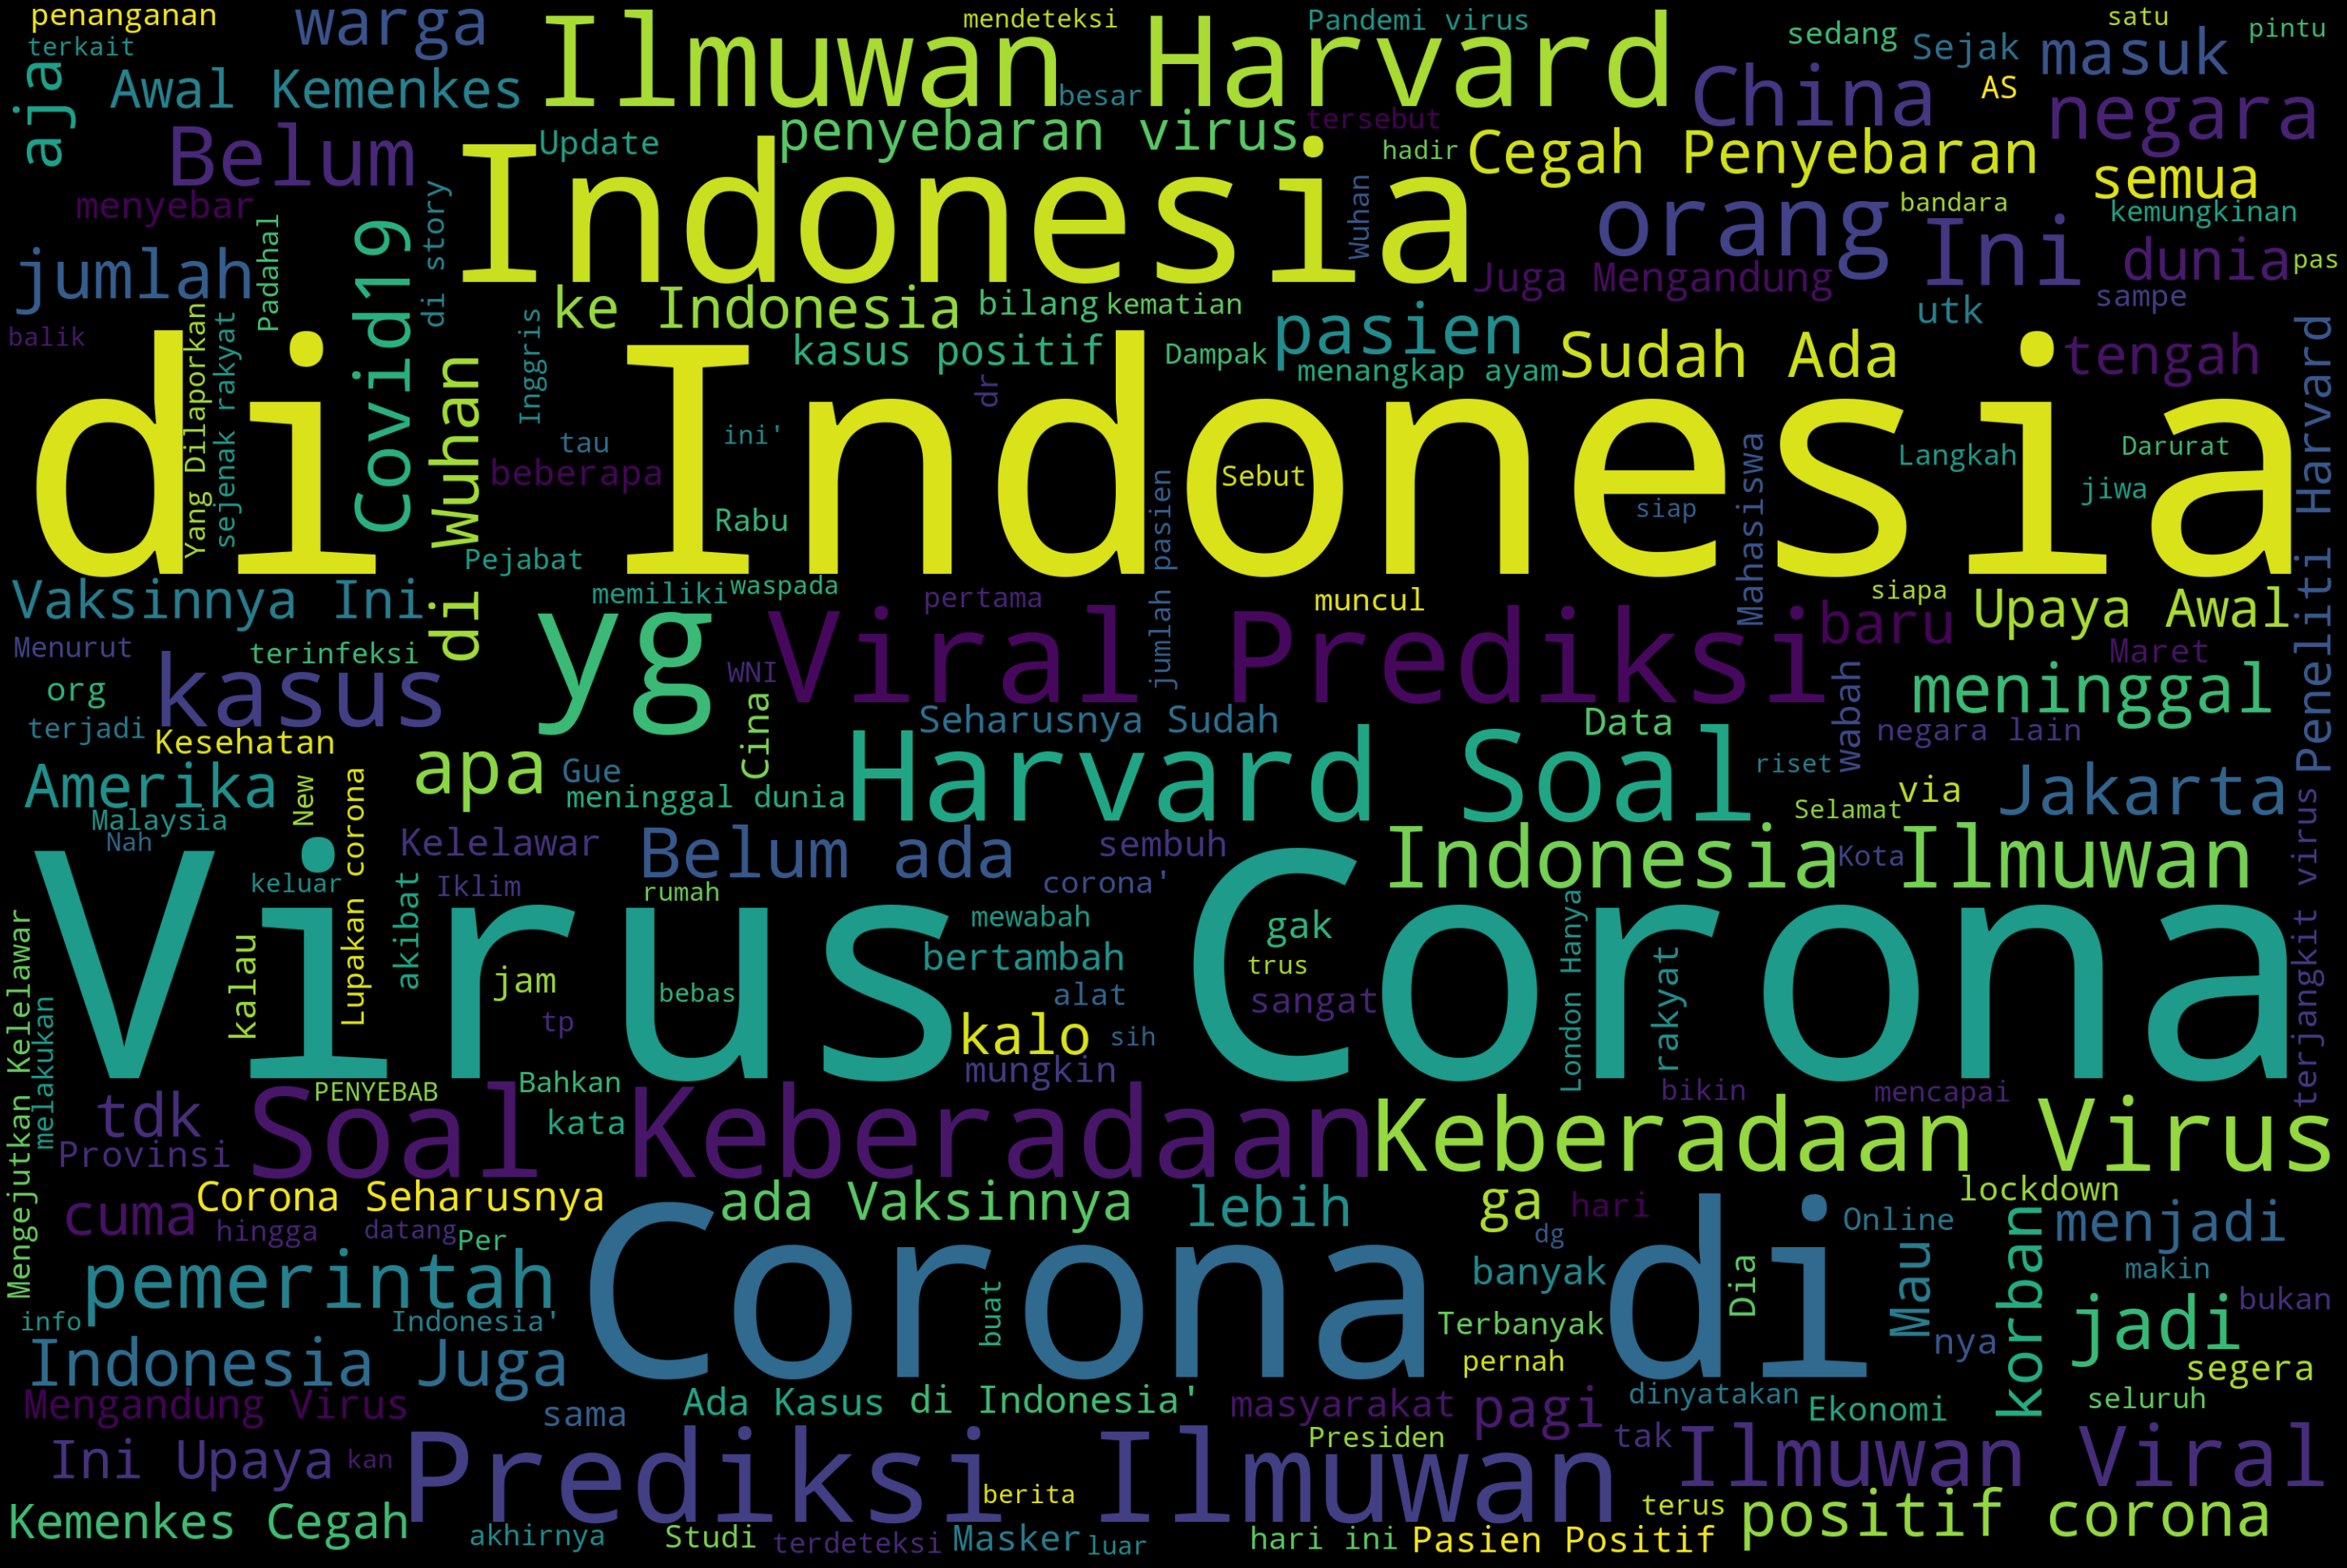

In [14]:
word_cloud(neutral_komen)

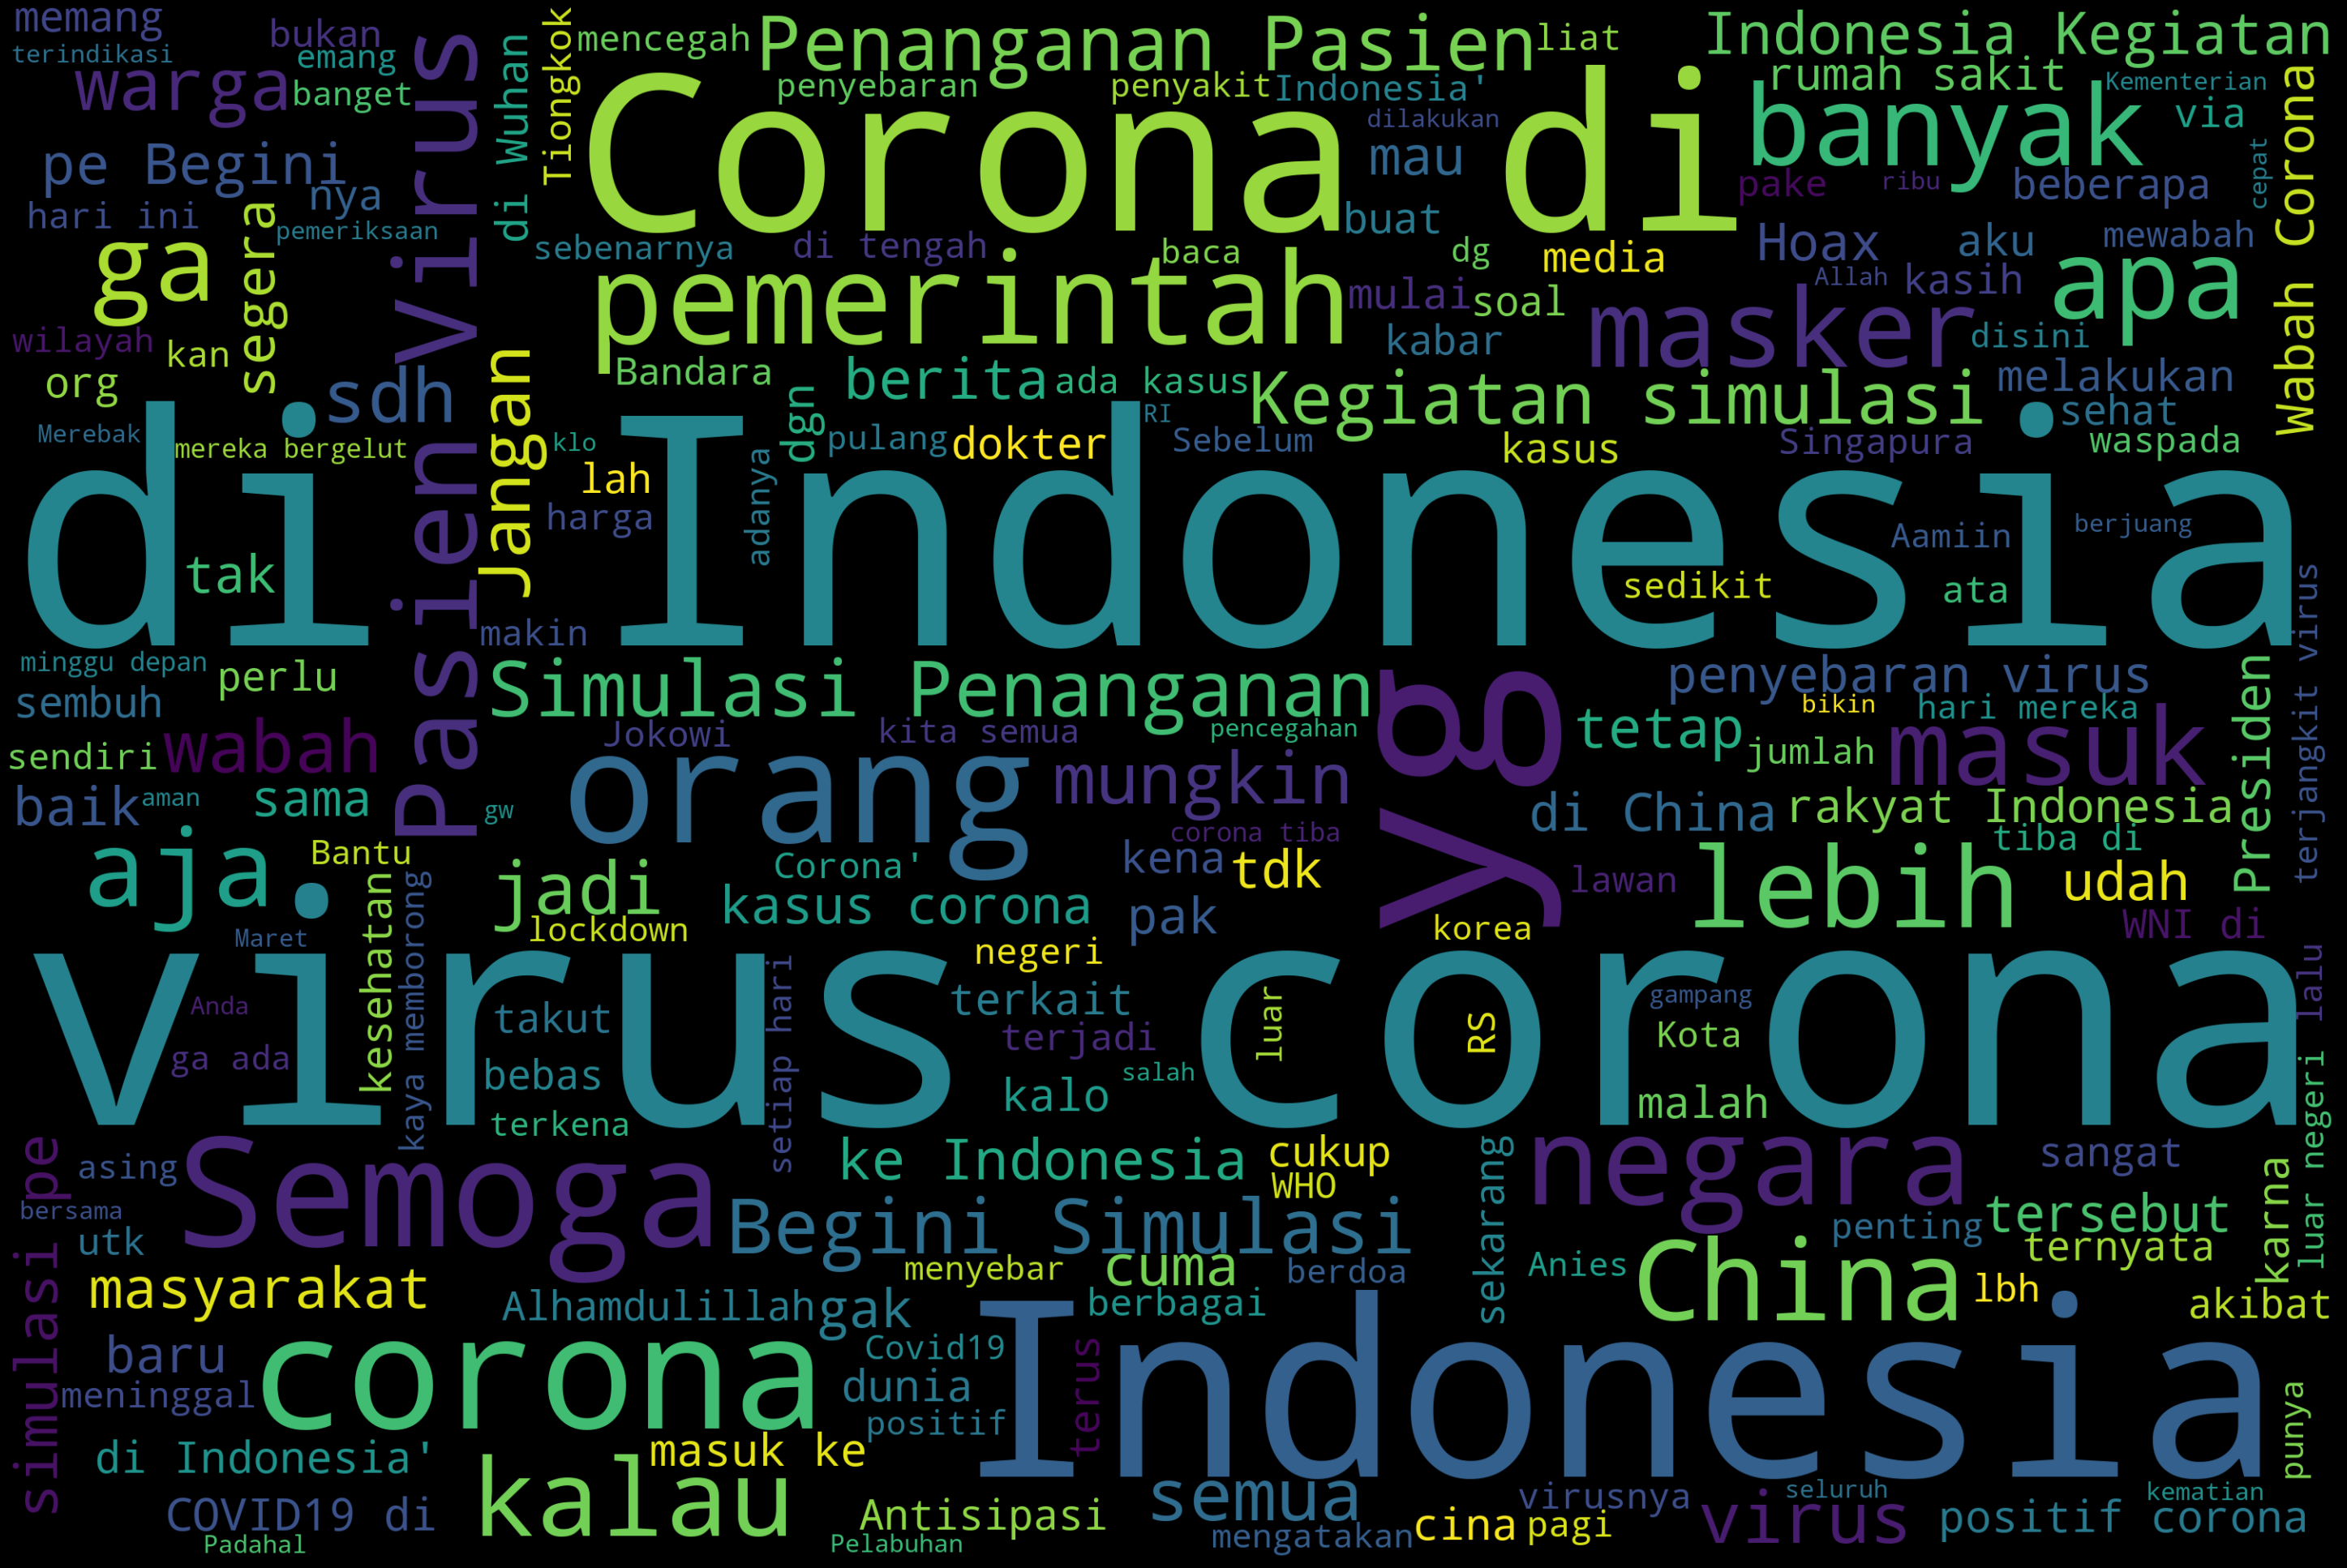

In [15]:
word_cloud(positif_komen)

In [16]:
df['komentar'] = df['komentar'].apply(lambda x: stemmer.stem(x))

In [17]:
for i in range(300, 310):
    print(f"sebelum stemming:\n {data['text'][i]}")
    print(f"setelah stemming:\n {df['komentar'][i]}\n")

sebelum stemming:
 Virus Corona Tak Bisa Bertahan di Negara Tropis Seperti Indonesia? http://dlvr.it/RP5yfP pic.twitter.com/TJLN4Vvbcc
setelah stemming:
 virus corona tak bisa tahan di negara tropis seperti indonesia

sebelum stemming:
 Kalo virus Corona masuk indonesia, gue yakin cuman jae doang yang gak bakal terinfeksi so virusnye pasti di kibulin sama doi diberi janji-janji sampe virusnya goyah & gajadi nginfeksi 
setelah stemming:
 kalo virus corona masuk indonesia gue yakin cuman jae doang yang gak bakal infeksi so virusnye pasti di kibulin sama doi beri janjijanji sampe virus goyah gajadi nginfeksi

sebelum stemming:
 Waduh, Terungkap Virus Corona Ternyata Sudah Ada di Indonesia Sejak 2015, Ini Hasil Risetnya
https://www.oposisicerdas.com/2020/01/waduh-terungkap-virus-corona-ternyata.html …
setelah stemming:
 waduh ungkap virus corona nyata sudah ada di indonesia sejak 2015 ini hasil riset

sebelum stemming:
 Campak memang C_nya di baca C bukan K,kalau Corona memang C_nya jadi K

In [18]:
df_clean = pd.DataFrame()
df_clean['Komentar_scraping'] = data['text']
df_clean['Komentar_clean'] = df['komentar']
df_clean['label'] = df['label']
df_clean.head(5)

Komentar_scraping  \
0  Beberapa bandara di Indonesia memamasang alat ...   
1  [NEWS] Kemenkes siap cegah penyebaran Virus Co...   
2  Virus Corona Menyebar di 13 Provinsi, Ini Peri...   
3  Corona Virus, virus yang muncul di China pada ...   
4  Khawatir virus Corona menyebar ke Indonesia, K...   

                                      Komentar_clean    label  
0  beberapa bandara di indonesia memamasang alat ...  neutral  
1  news kemenkes siap cegah sebar virus corona di...  neutral  
2  virus corona sebar di 13 provinsi ini perintah...  neutral  
3  corona virus virus yang muncul di china pada d...  neutral  
4  khawatir virus corona sebar ke indonesia mente...  neutral

In [19]:
df_clean.to_excel("cleaning_data.xlsx")

In [20]:
# pemisahan feature dan label
X = df['komentar']
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)
print(f"training size {X_train.size}")
print(f"validasi size {X_val.size}")

training size 1079
validasi size 120


In [21]:
# encoding data label menjadi numberik karena data awal berupa teks positif, neutral dan negatif
encoder = LabelEncoder()
y_train_code = encoder.fit_transform(y_train)
y_val_code = encoder.transform(y_val)
print(y_train_code[:10])
encoder.classes_ #negatif=0, neutral=1, positif=2

[1 1 1 1 2 2 0 0 2 1]


array(['negative', 'neutral', 'positive'], dtype=object)

Text(0.5, 1.0, 'Data Training')

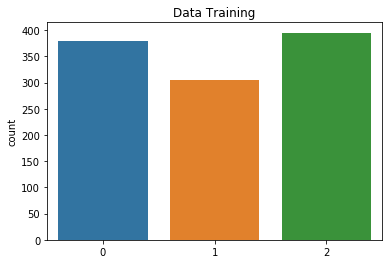

In [22]:
sns.countplot(y_train_code)
plt.title('Data Training')

Text(0.5, 1.0, 'Data Validasi')

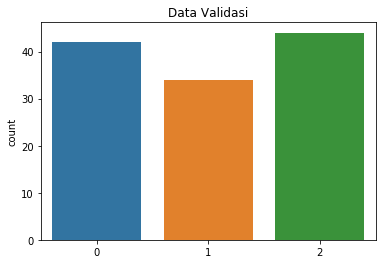

In [23]:
sns.countplot(y_val_code)
plt.title('Data Validasi')

## Tokenisasi and Vocabulary building


In [24]:
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words=stopwords)
#min_df = minimal kata minimal muncul 3 kali di dokumen
#stopwords = menghilangkan kata yang sering muncul di bahasa indonesia

#fit dan data tranformasi
bag_of_words = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)

feature_names = vectorizer.get_feature_names()
print(feature_names[200:215])
print(feature_names[1000:1015])

#model fit
mnNB = MultinomialNB()
mnNB.fit(bag_of_words, y_train_code)
print("\naccuracy training random 1 fold", mnNB.score(bag_of_words, y_train_code))
cv = cross_val_score(mnNB, bag_of_words, y_train_code, cv=10,scoring='accuracy') #data validasi
print("accuracy training random 10 fold", cv)
print("mean accuracy", np.mean(cv))

['amiin', 'amin', 'ampe', 'ampe sebar', 'ampun', 'ampun kota', 'anak', 'anak sekolah', 'ancam', 'ancam virus', 'and', 'and finance', 'android', 'android ios', 'aneh']
['diri covid19', 'diri cuman', 'diri heran', 'diri sendiri', 'diri sini', 'distancing', 'ditutuptutupi', 'dki', 'dlam', 'dlam keadaab', 'dlm', 'dlu', 'dn', 'dn bebas', 'dn indonesia']

accuracy training random 1 fold 0.8461538461538461
accuracy training random 10 fold [0.68518519 0.67592593 0.64814815 0.55555556 0.62037037 0.59259259
 0.64814815 0.56481481 0.60185185 0.64485981]
mean accuracy 0.6237452405676704


## Modelling

### Model Selection

In [25]:
#model selection untuk memilih model machine learning mana yang memberikan hasil yg baik
models = {'SVC' : SVC(), 'LogisticRegression': LogisticRegression(), 'MultinomialNB': MultinomialNB(),
         'RidgeClassifier' : RidgeClassifier(), 'KNeighborsClassifier':KNeighborsClassifier()}

score={}
for n, model in models.items():
    score[n] = np.mean(cross_val_score(model, bag_of_words, y_train_code, cv=10,scoring='accuracy'))

sorted(score.items(), key=lambda x:x[1], reverse=True)

[('MultinomialNB', 0.6237452405676704),
 ('SVC', 0.6228193146417447),
 ('LogisticRegression', 0.6228193146417446),
 ('RidgeClassifier', 0.6033835237106265),
 ('KNeighborsClassifier', 0.5385167878158532)]

### Parameter Tuning Using Pipeline

In [26]:
#model parameter tuning
#random search untuk mencari parameter kasar sebelum dilakukan gridsearch
pipe_random = make_pipeline(TfidfVectorizer(stop_words=stopwords), MultinomialNB())
param = {'multinomialnb__alpha': [0.5, 0.6, 0.7, 1, 3, 5, 7],
        'tfidfvectorizer__ngram_range':[(1, 1), (1,2), (1,3), (1,4)],
        'tfidfvectorizer__min_df':[1, 2, 3, 4, 5]}

rand_search = RandomizedSearchCV(pipe_random, param_distributions=param, cv=10)
rand_search.fit(X_train, y_train_code)
print("Best cross-validation score: ", rand_search.best_score_)
print("Best parameters: ", rand_search.best_estimator_)

Best cross-validation score:  0.6293094496365523
Best parameters:  Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['yang', 'untuk', 'pada', 'ke',
                                             'para', 'namun', 'menu...
                                             'seperti', 'jika', 'jika',
                                             'sehingga', 'kembali', 'dan',
                                             'tidak', 'ini', 'karena', 'kepada',
                         

In [27]:
#grid search ini saya lakukan untuk mempersempit parameter tuning dari random search
pipe_grid = make_pipeline(TfidfVectorizer(stop_words=stopwords), MultinomialNB())
param = {'multinomialnb__alpha': [0.7, 0.8, 0.85, 0.88, 0.89, 0.9, 1],
        'tfidfvectorizer__ngram_range':[(1,2), (1,3), (1,4)],
        'tfidfvectorizer__min_df':[2, 3]}

grid = GridSearchCV(pipe_grid, param_grid=param, cv=10)
grid.fit(X_train, y_train_code)
print("Best cross-validation score: ", grid.best_score_)
print("Best parameters: ", grid.best_estimator_)

Best cross-validation score:  0.6237538940809968
Best parameters:  Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['yang', 'untuk', 'pada', 'ke',
                                             'para', 'namun', 'menu...
                                             'seperti', 'jika', 'jika',
                                             'sehingga', 'kembali', 'dan',
                                             'tidak', 'ini', 'karena', 'kepada',
                         

### Model Evaluation

In [28]:
pipe_v1 = make_pipeline(TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words=stopwords),
                     MultinomialNB(alpha=0.8))
pipe_v1.fit(X_train, y_train_code)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['yang', 'untuk', 'pada', 'ke',
                                             'para', 'namun', 'menu...
                                             'seperti', 'jika', 'jika',
                                             'sehingga', 'kembali', 'dan',
                                             'tidak', 'ini', 'karena', 'kepada',
                                             'oleh', 'saat', 'harus',
                      

training report
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       379
           1       0.92      0.72      0.81       305
           2       0.86      0.89      0.87       395

    accuracy                           0.86      1079
   macro avg       0.87      0.85      0.85      1079
weighted avg       0.86      0.86      0.86      1079



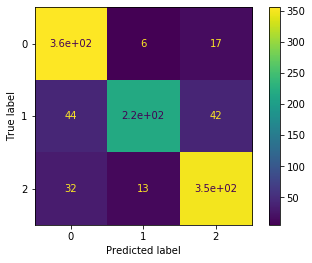

In [29]:
print('training report')
plot_confusion_matrix(pipe_v1, X_train, y_train_code)
print(classification_report(y_train_code, pipe_v1.predict(X_train)))

testing report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        42
           1       0.79      0.32      0.46        34
           2       0.58      0.70      0.64        44

    accuracy                           0.63       120
   macro avg       0.67      0.61      0.60       120
weighted avg       0.66      0.63      0.61       120



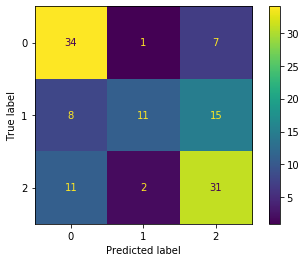

In [30]:
print('testing report')
plot_confusion_matrix(pipe_v1, X_val, y_val_code)
print(classification_report(y_val_code, pipe_v1.predict(X_val)))

catatan : model sepertinya overfitting terhadap data training akurasi 86% > 55%

## Saving the Model Pipeline

In [31]:
import joblib

# Save the model as a pickle in a file 
joblib.dump(pipe_v1, 'pipe_v1_covid19_sentiment.pkl') 
  
# Load the model from the file 
#model_joblib = joblib.load('filename.pkl')  
  
# Use the loaded model to make predictions 
#model_joblib.predict(X_test) 


['pipe_v1_covid19_sentiment.pkl']

## Fuzzy Membership

catatan : Menggunakan Data Validasi berjumlah 120 sampel

### Posterior Calculation 

In [32]:
# prediction prabablities pada data validasi
pasterior_Xval = pipe_v1.predict_proba(X_val)
predict_Xval = pipe_v1.predict(X_val)

In [33]:
#fungsi untuk menghitung fuzzy
def TriMF(x, a=0, b=0.5, c=1):
    """ A triangular MF is specified by three parameters {a, b, c}
    source: 
    https://www.mathworks.com/help/fuzzy/trimf.html
    """
    x1 = (x-a)/(b-a)
    x2 = (c-x)/(c-b)
    score = np.max((np.min((x1, x2), 0)))
    return score

In [34]:
#tabel akhir
tabel_fuzz = pd.DataFrame()
tabel_fuzz['Posterior_Negatif'] = pasterior_Xval[:,0]
tabel_fuzz['Posterior_Neutral'] = pasterior_Xval[:,1]
tabel_fuzz['Posterior_Positif'] = pasterior_Xval[:,2]
tabel_fuzz['Fuzzy_Negatif'] = [TriMF(x) for x in tabel_fuzz['Posterior_Negatif']]
tabel_fuzz['Fuzzy_Neutral'] = [TriMF(x) for x in tabel_fuzz['Posterior_Neutral']]
tabel_fuzz['Fuzzy_Positif'] = [TriMF(x) for x in tabel_fuzz['Posterior_Positif']]
tabel_fuzz['Prediction_NB'] = predict_Xval
tabel_fuzz['True_Label'] = y_val_code
tabel_fuzz['True_Label_String'] = list(y_val)
tabel_fuzz.head()

Posterior_Negatif  Posterior_Neutral  Posterior_Positif  Fuzzy_Negatif  \
0           0.206024           0.431612           0.362364       0.412048   
1           0.519756           0.159846           0.320398       0.960488   
2           0.670004           0.123495           0.206501       0.659993   
3           0.256246           0.324723           0.419031       0.512491   
4           0.395079           0.237834           0.367087       0.790158   

   Fuzzy_Neutral  Fuzzy_Positif  Prediction_NB  True_Label True_Label_String  
0       0.863223       0.724729              1           1           neutral  
1       0.319693       0.640795              0           0          negative  
2       0.246991       0.413002              0           0          negative  
3       0.649446       0.838062              2           2          positive  
4       0.475668       0.734174              0           2          positive

### Fuzzy Score Calculation

In [35]:
tes = tabel_fuzz[['Fuzzy_Negatif', 'Fuzzy_Neutral','Fuzzy_Positif']]
fuzzy_pre = []
for i in range(len(tes)):
    fuzzy_pre.append(np.argmax(tes.values[i]))
accuracy = sum(fuzzy_pre==y_val_code) / len(y_val_code) *100
accuracy

63.33333333333333

In [36]:
# #Accuracy untuk Fuzzy
# tes = tabel_fuzz[['Fuzzy_Negatif', 'Fuzzy_Neutral','Fuzzy_Positif']]
# #ist(tes.max(1))[0] in list(tabel_fuzz['Fuzzy_Negatif'])
# fuzzy_label = []
# for i in range(len(tes)):
#     if list(tes.max(1))[i] in list(tabel_fuzz['Fuzzy_Negatif']):
#         fuzzy_label.append(0)
#     elif list(tes.max(1))[i] in list(tabel_fuzz['Fuzzy_Neutral']):
#         fuzzy_label.append(1)
#     elif list(tes.max(1))[i] in list(tabel_fuzz['Fuzzy_Positif']):
#         fuzzy_label.append(2)
# accuracy = sum(fuzzy_label==y_val_code) / len(y_val_code) *100
# accuracy

In [37]:
tabel_fuzz['Prediction_Fuzzy'] = fuzzy_pre
tabel_fuzz

Posterior_Negatif  Posterior_Neutral  Posterior_Positif  Fuzzy_Negatif  \
0             0.206024           0.431612           0.362364       0.412048   
1             0.519756           0.159846           0.320398       0.960488   
2             0.670004           0.123495           0.206501       0.659993   
3             0.256246           0.324723           0.419031       0.512491   
4             0.395079           0.237834           0.367087       0.790158   
..                 ...                ...                ...            ...   
115           0.238268           0.186953           0.574778       0.476536   
116           0.100139           0.437142           0.462718       0.200279   
117           0.649048           0.170255           0.180697       0.701904   
118           0.579131           0.105549           0.315320       0.841738   
119           0.583008           0.171276           0.245716       0.833984   

     Fuzzy_Neutral  Fuzzy_Positif  Prediction_NB  True_Label  \
0         0.863223       0.724729              1           1   
1         0.319693       0.640795              0           0   
2         0.246991       0.413002              0           0   
3         0.649446       0.838062              2           2   
4         0.475668       0.734174              0           2   
..             ...            ...            ...         ...   
115       0.373907       0.850443              2           0   
116       0.874285       0.925437              2           1   
117       0.340510       0.361393              0           2   
118       0.211097       0.630640              0           0   
119       0.342553       0.491432              0           0   

    True_Label_String  Prediction_Fuzzy  
0             neutral                 1  
1            negative                 0  
2            negative                 0  
3            positive                 2  
4            positive                 0  
..                ...               ...  
115          negative                 2  
116           neutral                 2  
117          positive                 0  
118          negative                 0  
119          negative                 0  

[120 rows x 10 columns]

### Fuzzy Score Evalution

Accuracy: 63.33
Precision [0.64150943 0.78571429 0.58490566] mean 0.6707097933513028
Recall [0.80952381 0.32352941 0.70454545] mean 0.6125328919446567
f1 [0.71578947 0.45833333 0.63917526] mean 0.6044326882498341
support [42 34 44] mean 40.0


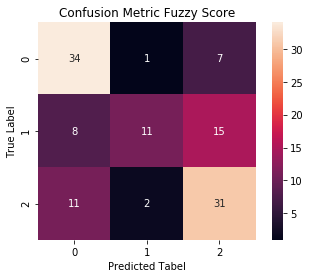

In [38]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

metric = confusion_matrix(y_val_code, fuzzy_pre)
plt.title('Confusion Metric Fuzzy Score')
sns.heatmap(metric, annot=True, square=True)
plt.ylabel('True Label'); plt.xlabel('Predicted Tabel')
precision, recall, f1, support = precision_recall_fscore_support(y_val_code, fuzzy_pre)
print("Accuracy:", round(accuracy, 2))
print("Precision", precision, "mean", np.mean(precision))
print("Recall", recall, "mean", np.mean(recall))
print("f1", f1, "mean", np.mean(f1))
print("support", support,"mean", np.mean(support))

In [39]:
tabel_fuzz.to_excel('class_pasterior.xlsx')

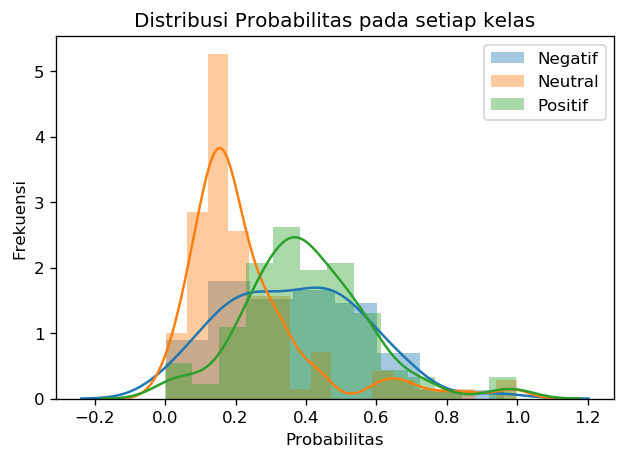

In [40]:
plt.figure(dpi=120)
sns.distplot(tabel_fuzz['Posterior_Negatif'], label='Negatif')
sns.distplot(tabel_fuzz['Posterior_Neutral'], label='Neutral')
sns.distplot(tabel_fuzz['Posterior_Positif'], label='Positif')
plt.title('Distribusi Probabilitas pada setiap kelas')
plt.xlabel('Probabilitas'); plt.ylabel('Frekuensi')
plt.legend()

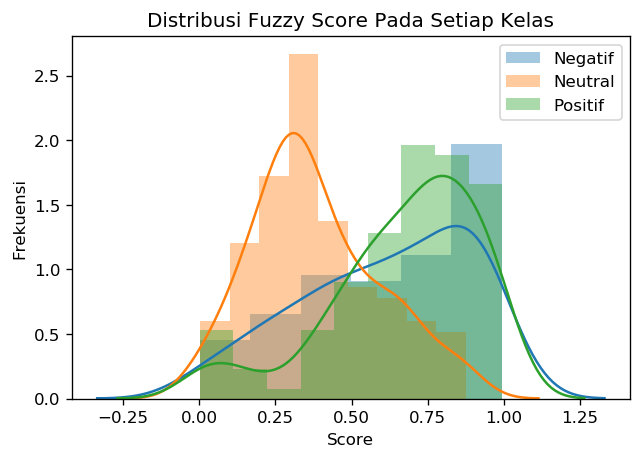

In [41]:
plt.figure(dpi=120)
sns.distplot(tabel_fuzz['Fuzzy_Negatif'], label='Negatif')
sns.distplot(tabel_fuzz['Fuzzy_Neutral'], label='Neutral')
sns.distplot(tabel_fuzz['Fuzzy_Positif'], label='Positif')
plt.title('Distribusi Fuzzy Score Pada Setiap Kelas')
plt.xlabel('Score'); plt.ylabel('Frekuensi')
plt.legend()